# Coagulation Basic 4: Particle Resolved

**Introduction**

In aerosol science, understanding particle-particle interactions is crucial for predicting the evolution of particle size distributions. One such interaction is **coagulation**, where two particles collide and merge into a larger particle. Accurately modeling coagulation at the level of individual particles is known as the **particle-resolved method**.

The particle-resolved method tracks each particle individually, considering its unique properties and interactions. This method provides the most detailed representation of aerosol dynamics, making it ideal for cases where precision is paramount, such as in cloud microphysics or laboratory-scale studies.

However, this approach is computationally intensive because it requires simulating every individual particle and its interactions. Unlike the **super droplet method**, which uses statistical representations to reduce computational load, the direct particle-resolved method does not aggregate particles into larger groups. Instead, every particle is treated independently, ensuring that every interaction is explicitly modeled.

This notebook provides a step-by-step guide to simulating coagulation using a pure particle-resolved approach, demonstrating how individual particles evolve over time without any simplifications or approximations in particle grouping.

**Setup and Imports**

We'll start by importing the necessary libraries and setting up the environment.

In [ ]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
# %% particle resolved coagulation example
import numpy as np  # For numerical operations and array manipulations
import matplotlib.pyplot as plt  # For plotting graphs and visualizations

import particula as par  # Import the particula module

## Generating Distribution

In this section, we generate a sample particle size distribution following a lognormal distribution. The lognormal distribution is commonly used in aerosol science to describe particle size distributions. 

**Coagulation Kernel**

We also calculate the Brownian coagulation kernel for these particles, which quantifies the probability of coagulation between particles of different sizes.

**Random seed**

We set a random seed to ensure reproducibility of the results.

In [18]:
# lognormal spacing

radius_bins = np.logspace(
    -9, -6, num=20
)  # Define the radius bins for the distribution
mass_bins = (
    4 / 3 * np.pi * radius_bins**3 * 1000
)  # Calculate the mass of the particles in the bins

kernel = par.dynamics.get_brownian_kernel_via_system_state(
    particle_radius=radius_bins,
    particle_mass=mass_bins,
    temperature=298.15,
    pressure=101325,
)  # Calculate the Brownian coagulation kernel for the radius bins

random_generator = np.random.default_rng(12345)

**Sampling the Particle Distribution**

We then sample particles from the lognormal distribution. These particles will be sorted by size to prepare for the coagulation step.

In [19]:
# %% sample particle distribution
particle_radius = par.particles.get_lognormal_sample_distribution(
    mode=np.array([1e-8, 1e-7]),
    geometric_standard_deviation=np.array([1.4, 1.4]),
    number_of_particles=np.array([5000, 1000]),
    number_of_samples=10_000,
)
# particle_radius = np.sort(particle_radius)
particles_original = particle_radius.copy()

## Coagulation Step

In the coagulation step, particles collide and merge over a given time step. The super droplet method efficiently simulates this process by adjusting the particle sizes and concentrations based on the calculated kernel and the specified volume and time step.

In [20]:
# %% Coagulation step

delta_t = 100  # time step in seconds
total_number_concentration = 1_000_000 * 1e6  # particles per m^3
total_number_tracked = len(particle_radius)
volume_sim = total_number_tracked / total_number_concentration

loss_gain_index = par.dynamics.get_particle_resolved_coagulation_step(
    particle_radius=particle_radius,
    kernel=kernel,
    kernel_radius=radius_bins,
    volume=volume_sim,
    time_step=delta_t,
    random_generator=random_generator,
)
particle_radius, gain, loss = par.dynamics.get_particle_resolved_update_step(
    particle_radius=particle_radius,
    gain=np.zeros_like(particle_radius),
    loss=np.zeros_like(particle_radius),
    small_index=loss_gain_index[:, 0],
    large_index=loss_gain_index[:, 1],
)

print(loss_gain_index.shape)
print(loss_gain_index)

(3201, 2)
[[3074 9486]
 [3535 9551]
 [2105 3968]
 ...
 [9772 8800]
 [9111 8947]
 [9496 8414]]


**Plotting the New Distribution**

Finally, we plot the particle size distribution before and after coagulation. This visualization helps us understand the effect of the coagulation process on the particle size distribution.


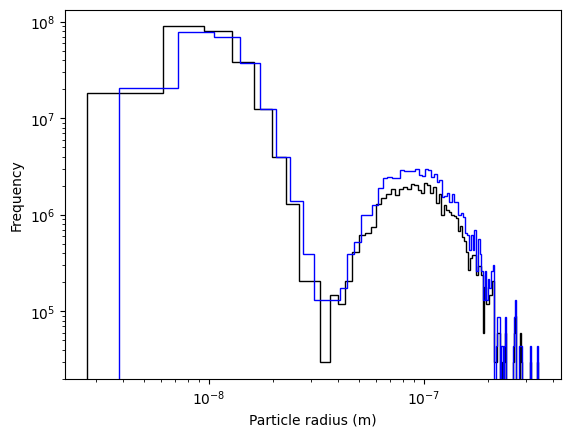

In [21]:
# %% plot new distribution
fig, ax = plt.subplots()
ax.hist(
    particles_original, bins=100, histtype="step", color="black", density=True
)
ax.hist(
    particle_radius[particle_radius > 0],
    bins=100,
    histtype="step",
    color="blue",
    density=True,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Frequency")
plt.show()

**Plotting the Loss and Gain of Particles**

We also plot the loss and gain of particles due to coagulation. This visualization provides insights into the coagulation process and how it affects the particle population.

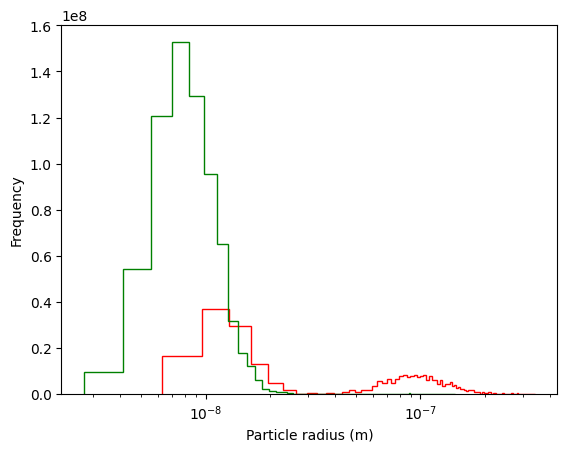

In [22]:
fig, ax = plt.subplots()
ax.hist(loss[loss > 0], bins=100, histtype="step", color="red", density=True)
ax.hist(gain[gain > 0], bins=100, histtype="step", color="green", density=True)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Frequency")
plt.show()

## Direct Time Stepping

With the first coagulation step completed, we can now proceed to the next time step. We repeat the coagulation process for the new particle distribution, updating the particle sizes and concentrations accordingly. This iterative approach allows us to simulate the evolution of the particle size distribution over time.

Here we use a simple for loop to perform multiple coagulation steps. In practice, more sophisticated time-stepping methods may be used to improve efficiency and accuracy.

In [23]:
# Initial distribution for the simulation
particles_0 = particles_original
particles_i = particles_0

# Define the time array for the simulation
time_array = np.linspace(
    start=0, stop=1000, num=100
)  # Time span of 1000 seconds
time_interval = (
    time_array[1] - time_array[0]
)  # Time interval between each step

# Array to store the distribution at each time step
particles_matrix = np.zeros([len(time_array), len(particles_0)])

# Simulate the coagulation process over time
for i, dpa in enumerate(time_array):
    if i > 0:

        loss_gain_index = par.dynamics.get_particle_resolved_coagulation_step(
            particle_radius=particles_i,
            kernel=kernel,
            kernel_radius=radius_bins,
            volume=volume_sim,
            time_step=time_interval,
            random_generator=random_generator,
        )
        particles_i, _, _ = par.dynamics.get_particle_resolved_update_step(
            particle_radius=particles_i,
            gain=np.zeros_like(particles_i),
            loss=np.zeros_like(particles_i),
            small_index=loss_gain_index[:, 0],
            large_index=loss_gain_index[:, 1],
        )

        # Ensure no negative concentrations (set to zero if less than zero)
        particles_i[particles_i < 0] = 0

    # Store the updated distribution for the current time step
    particles_matrix[i, :] = particles_i

**Plotting the Final Distribution**

Finally, we plot the final particle size distribution after multiple coagulation steps. This visualization shows how the particle size distribution evolves over time due to coagulation.

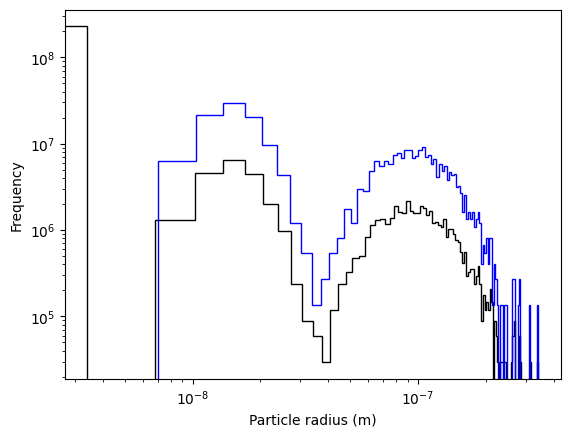

In [24]:
filtered = particles_matrix[-1, :] > 0

fig, ax = plt.subplots()
ax.hist(
    particles_original, bins=100, histtype="step", color="black", density=True
)
ax.hist(
    particles_matrix[-1, filtered],
    bins=100,
    histtype="step",
    color="blue",
    density=True,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Frequency")
plt.show()

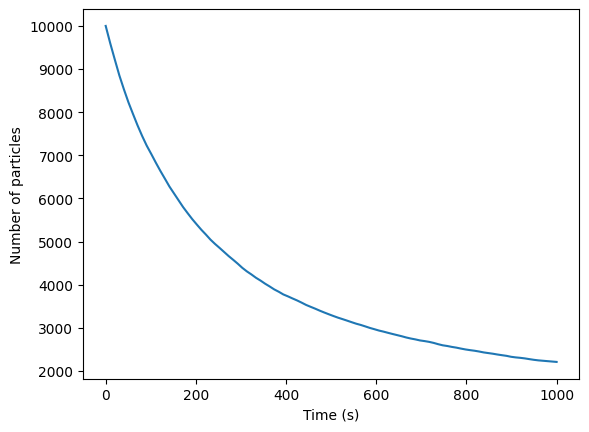

In [25]:
# plot total number of particles
total_number = np.sum(particles_matrix > 0, axis=1)

fig, ax = plt.subplots()
ax.plot(time_array, total_number)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Number of particles")
plt.show()

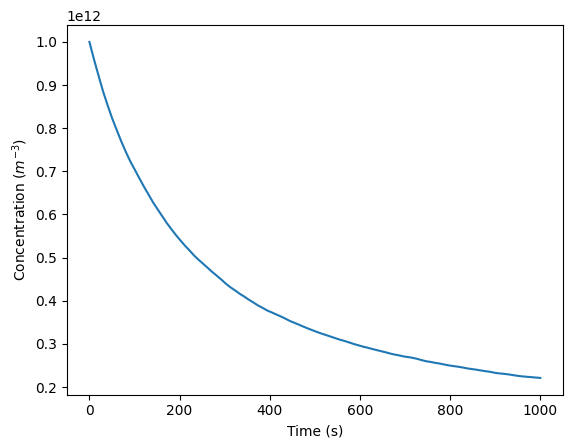

In [26]:
# convert to concentration
total_concentration = total_number / volume_sim

fig, ax = plt.subplots()
ax.plot(time_array, total_concentration)
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Concentration $(m^{-3})$")
plt.show()

## Conclusion

This notebook demonstrated the use of the particle resolved coagulation method to simulate particle coagulation.
